# Project 4 - West Nile (Kaggle)

## Problem Statement

A recent epidemic of West Nile Virus in the Windy City has led to the Department of Public Health set up a surveillance and control system. A greater understanding of the mosquito population and its association with the spread of the West Nile Virus needs to be acquired.

## Executive Summary

This project seeks to build an ML model that can help provide recommendations on controlling the mosquito population that will help curtail the spread of the West Nile virus.

### Contents:
- [Importing Libraries & Loading Data](#Importing-Libraries-&-Loading-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Modelling](#Modelling)
- [Key Findings](#Key-Findings)
- [Cost-Benefit Analysis & Recommendations](#Cost-Benefit-Analysis-&-Recommendations)

## Importing Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import geopy.distance

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

Using TensorFlow backend.
/Users/zhiyong/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
train = pd.read_csv ('./train.csv')
test = pd.read_csv ('./test.csv')
weather = pd.read_csv ('./weather.csv')
spray = pd.read_csv ('./spray.csv')

## Exploratory Data Analysis

### Train Dataset

In [3]:
# Drop Columns for Train Dataset (Details already in "Address")
train.drop(columns = ['Street','Block','AddressNumberAndStreet'], inplace=True)
train.head()

,Date,Address,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 9 columns):
Date               10506 non-null object
Address            10506 non-null object
Species            10506 non-null object
Trap               10506 non-null object
Latitude           10506 non-null float64
Longitude          10506 non-null float64
AddressAccuracy    10506 non-null int64
NumMosquitos       10506 non-null int64
WnvPresent         10506 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 738.8+ KB


In [5]:
train.head()

,Date,Address,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0


In [6]:
train.Date = pd.to_datetime(train.Date)

### Test Dataset

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [8]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [9]:
# Drop Columns for Test Dataset (Details already in "Address")
test.drop(columns = ['Street','Block','AddressNumberAndStreet'], inplace=True)
test.head()

,Id,Date,Address,Species,Trap,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,T002,41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,T002,41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,T002,41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,T002,41.95469,-87.800991,9


In [10]:
test.Date = pd.to_datetime(test.Date)

### Weather Dataset

In [11]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [12]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [13]:
# Check for missing values 'M' or NaN
for c in weather.columns:
    print(c, weather[weather[c].isin(['M', 'T'])][c].count())

Station 0
Date 0
Tmax 0
Tmin 0
Tavg 11
Depart 1472
DewPoint 0
WetBulb 4
Heat 11
Cool 11
Sunrise 0
Sunset 0
CodeSum 0
Depth 1472
Water1 2944
SnowFall 1472
PrecipTotal 2
StnPressure 4
SeaLevel 9
ResultSpeed 0
ResultDir 0
AvgSpeed 3


### Average Temperature

In [14]:
# Replace missing values with average of max and min temperature

weather['Tavg'].replace('M',(weather['Tmax']+ weather['Tmin'])/2,inplace=True)

### Depart Temperature

In [15]:
# Replace missing values via forward-filling

weather['Depart'] = weather['Depart'].replace('M',np.nan)
weather['Depart'].ffill(axis='rows',inplace=True)

### Wet Bulb Temperature

In [16]:
# Replace missing values with corresponding station's wetbulb temperature

for i,index in enumerate(weather[weather['WetBulb']=='M'].index):
    print(i,index)
    if weather.loc[index,'Station'] == 1:
        weather.loc[index,'WetBulb'] = weather.loc[index+1,'WetBulb']
    else:
        weather.loc[index,'WetBulb'] = weather.loc[index-1,'WetBulb']

0 848
1 2410
2 2412
3 2415


### Heating & Cooling

In [17]:
# Using T-avg value to derive heating and cooling temperature for missing values

for i,index in enumerate(weather[weather['Heat']=='M'].index):
    print(i,index)
    result = weather.loc[index, 'Tavg'] - 65
    if result > 0:
        weather.loc[index, 'Heat'] = int(result)
        weather.loc[index, 'Cool'] = int(0)
    else:
        weather.loc[index, 'Cool'] = abs(result)
        weather.loc[index, 'Heat'] = int(0)

0 7
1 505
2 675
3 1637
4 2067
5 2211
6 2501
7 2511
8 2525
9 2579
10 2811


### Sunrise and Sunset

In [18]:
# Forward-filling missing values

weather['Sunrise'] = weather['Sunrise'].replace('-',np.nan)
weather['Sunrise'].ffill(axis='rows',inplace=True)

weather['Sunset'] = weather['Sunset'].replace('-',np.nan)
weather['Sunset'].ffill(axis='rows',inplace=True)

### Converting Variables To Correct Data Types

In [19]:
#convert 'Date' to date datatype
weather['Date']= pd.to_datetime(weather['Date']) 

#convert 'Tavg' to int
weather['Tavg'] = weather['Tavg'].astype(int)

#convert 'Depart' to int
weather['Depart'] = weather['Depart'].astype(int)

#convert 'WetBulb' to int
weather['WetBulb'] = weather['WetBulb'].astype(int)

#convert 'Heat','Cool' to int
weather['Heat'] = weather['Heat'].astype(int)
weather['Cool'] = weather['Cool'].astype(int)

### Code Sum

In [20]:
#Replace empty values as 'No Sign'
weather['CodeSum'] = weather['CodeSum'].replace(to_replace = ' ', value = 'No Sign')

### Depth, Water1, Snowfall

In [21]:
# Replace missing values with 0 and converting to numeric type

weather['Depth'] = weather['Depth'].replace('M', 0)
weather['Depth']=pd.to_numeric(weather['Depth'])

In [22]:
# Drop Water1 column as there are too many missing values

weather = weather.drop(['Water1'], axis=1)

In [23]:
# Replace missing and trace values with 0 and converting to numeric type

weather['SnowFall'] = weather['SnowFall'].replace('M', 0)
weather['SnowFall'] = weather['SnowFall'].replace('  T', 0)
weather['SnowFall'] = pd.to_numeric(weather['SnowFall'])

### Precipitation

In [24]:
# Replace missing and trace values with 0

weather['PrecipTotal'] = weather['PrecipTotal'].replace('  T', 0.00)
weather['PrecipTotal'] = weather['PrecipTotal'].replace('M', 0.00)
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

### Station Pressure

In [25]:
# Replace missing values with NaN values and fill it with mean value

weather['StnPressure'] = weather['StnPressure'].replace(to_replace='M', value=np.nan)
weather['StnPressure'] = weather['StnPressure'].fillna(round(weather['StnPressure'].astype(float).mean(),2))
weather['StnPressure']=pd.to_numeric(weather['StnPressure'])

### Sea Level

In [26]:
# Replace missing values with NaN values and converting to float type

weather['SeaLevel'] = weather['SeaLevel'].apply(lambda x: np.nan if x == 'M' else x)
weather['SeaLevel'] = weather['SeaLevel'].fillna(round(weather['SeaLevel'].astype(float).mean(),2))
weather['SeaLevel'] = pd.to_numeric(weather['SeaLevel'])

### Average Speed

In [27]:
# Replace missing values with NaN values and forward-fill before converting to numeric type

weather['AvgSpeed'] = weather['AvgSpeed'].replace('M', np.nan)
weather['AvgSpeed'].ffill(axis='rows', inplace=True)
weather['AvgSpeed']=pd.to_numeric(weather['AvgSpeed'])

In [28]:
# Check for null values

weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [29]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                    int64
Depart                  int64
DewPoint                int64
WetBulb                 int64
Heat                    int64
Cool                    int64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                   int64
SnowFall              float64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

### Spray Dataset

In [30]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [31]:
spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [32]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [33]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [34]:
# Check for null values

spray[spray['Time'].isnull()]

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


In [35]:
# Check for observations before and after null values

spray.iloc[[1029, 1614]]

,Date,Time,Latitude,Longitude
1029,2011-09-07,7:44:32 PM,41.986460,-87.794225
1614,2011-09-07,7:46:30 PM,41.973465,-87.827643


In [36]:
# Fill NaN values with time between afore-mentioned observations

spray.fillna('7:45:00 PM', inplace = True)

In [37]:
spray['Time'] = pd.to_datetime(spray['Time'],format= '%I:%M:%S %p').dt.time

In [38]:
spray.Date = pd.to_datetime(spray.Date)

## Feature Engineering

In [39]:
# Function to calculate distance to station 1 and 2 & return correct station

def get_nearest_station(lat, long):
    station1_lat = 41.995
    station1_long = -87.933
    station2_lat = 41.786
    station2_long = -87.752
    
    station1_km = geopy.distance.vincenty((station1_lat,station1_long),(lat,long)).km
    station2_km = geopy.distance.vincenty((station2_lat,station2_long),(lat,long)).km
    
    if station1_km < station2_km: 
        return 1
    else:
        return 2

In [40]:
# Create new train copy and create 'Station' column with corresponding values calculated from 'get_nearest_station' function

train_prep = train.copy()

for index in train_prep.index:    
    train_prep.loc[index,'Station'] = get_nearest_station(train_prep.loc[index,'Latitude'],train_prep.loc[index,'Longitude'])

train_prep['Station'] = train_prep['Station'].astype(int)
train_prep['Station'].value_counts()

/Users/zhiyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/zhiyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


2    7208
1    3298
Name: Station, dtype: int64

In [41]:
# Create new train copy and create 'Station' column with corresponding values calculated from 'get_nearest_station' function

test_prep = test.copy()

for index in test_prep.index:
    test_prep.loc[index,'Station'] = get_nearest_station(test_prep.loc[index,'Latitude'],test_prep.loc[index,'Longitude'])
    
test_prep['Station'] = test_prep['Station'].astype(int)
test_prep['Station'].value_counts()

/Users/zhiyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if __name__ == '__main__':
/Users/zhiyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


2    80892
1    35401
Name: Station, dtype: int64

In [42]:
# Join train_prep data with weather data on date/station to merge them into the same dataframe

train_weather = pd.merge(train_prep,weather,how='left', on=['Date','Station'])

In [43]:
# Join test_prep data with weather data on date/station to merge them into the same dataframe

test_weather = pd.merge(test_prep,weather,how='left', on=['Date','Station'])

### Distribution of Data

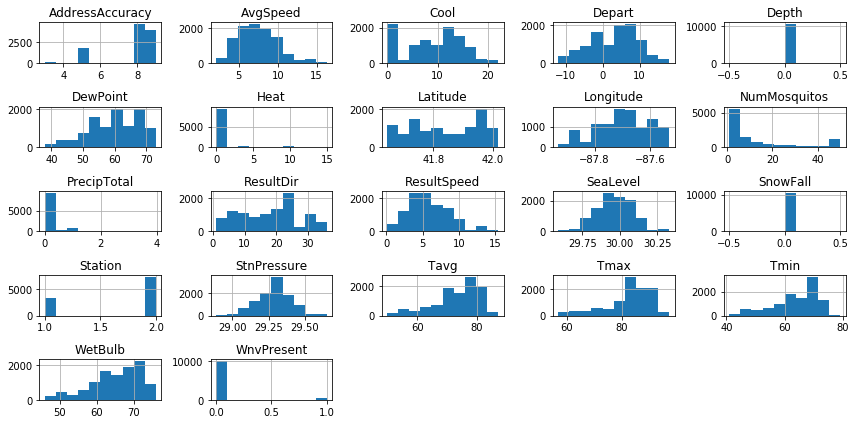

In [44]:
# Plot histogram of distributions of features

train_weather.hist(figsize = (12, 6));
plt.tight_layout()

In [45]:
# Creating Columns for Year, Month, Week, Day
train_weather['year'] = train_weather['Date'].dt.year
train_weather['month'] = train_weather['Date'].dt.month
train_weather['week'] = train_weather['Date'].dt.week
train_weather['day'] = train_weather['Date'].dt.day

In [46]:
# Groupby year, month and day to find the total number of Mosquitos caught on that day and the number of observations of WnvPresent
train_weather_gb = train_weather.groupby(['year','month','day'])[['WnvPresent', 'NumMosquitos']].sum()
train_weather_gb

WnvPresent  NumMosquitos
year month day                          
2007 5     29            0            40
     6     5             0           127
           26            0           216
           29            0            85
     7     2             0           240
...                    ...           ...
2013 8     29           38          2645
     9     6            32          2510
           12           23          2210
           19           11          1030
           26            4           505

[95 rows x 2 columns]

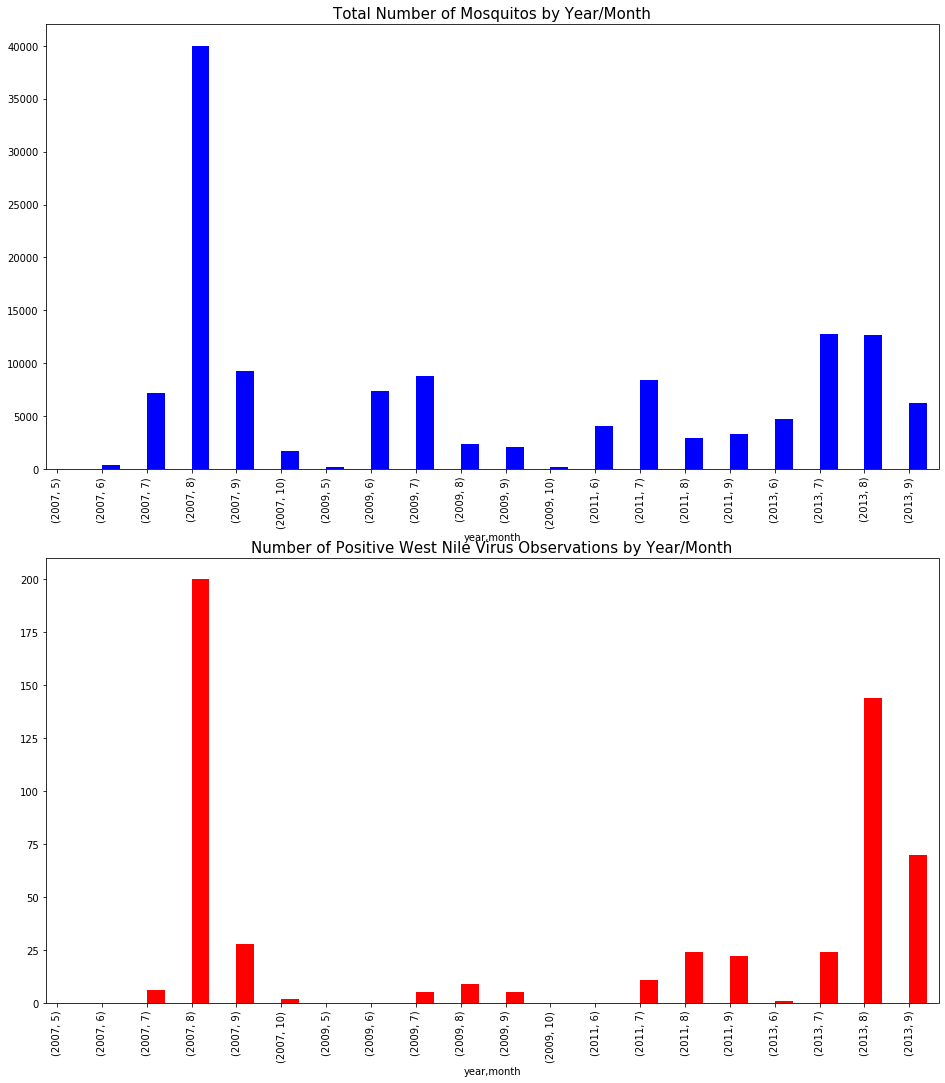

In [47]:
# Plot Barplots for WnvPresent and NumMosquitos
plt.figure(figsize=(16,18))
plt.subplot(211)
plt.title("Total Number of Mosquitos by Year/Month", fontsize=15)
train_weather_gb.groupby(['year','month'])['NumMosquitos'].sum().plot.bar(color = 'b',width = 0.4, align = 'edge')
plt.subplot(212)
plt.title("Number of Positive West Nile Virus Observations by Year/Month", fontsize=15)
train_weather_gb.groupby(['year','month'])['WnvPresent'].sum().plot.bar(color = 'r',width = 0.4, align = 'edge')

#### It can be observed that mosquito populations and number of West Nile virus observations peak during the July-August period.

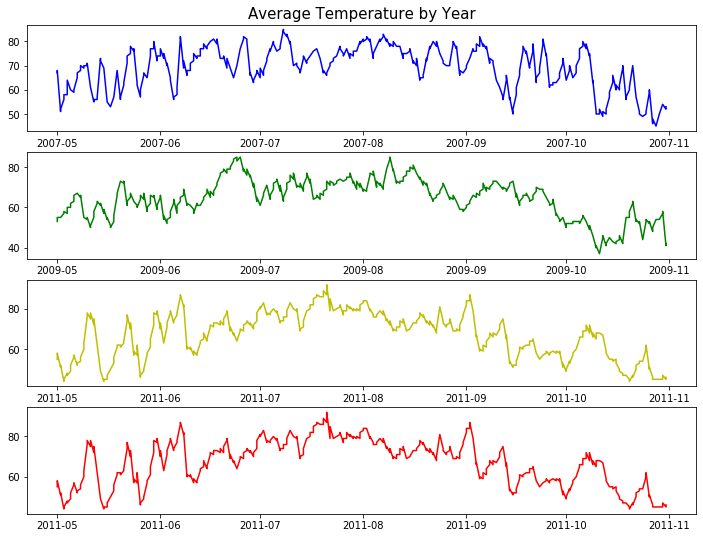

In [48]:
# Plot Average Temperature Across Different Years

temp_df = weather.set_index('Date')
fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Average Temperature by Year", fontsize=15)
axes[0].plot(temp_df['2007-05' : '2007-12']['Tavg'],c='b') # first plot
axes[1].plot(temp_df['2009-05' : '2009-12']['Tavg'],c='g') # second plot
axes[2].plot(temp_df['2011-05' : '2011-12']['Tavg'],c='y') # third plot
axes[3].plot(temp_df['2011-05' : '2011-12']['Tavg'],c='r') # third plot

#### It can be observed that the average temperature also peaks during the July-August period.

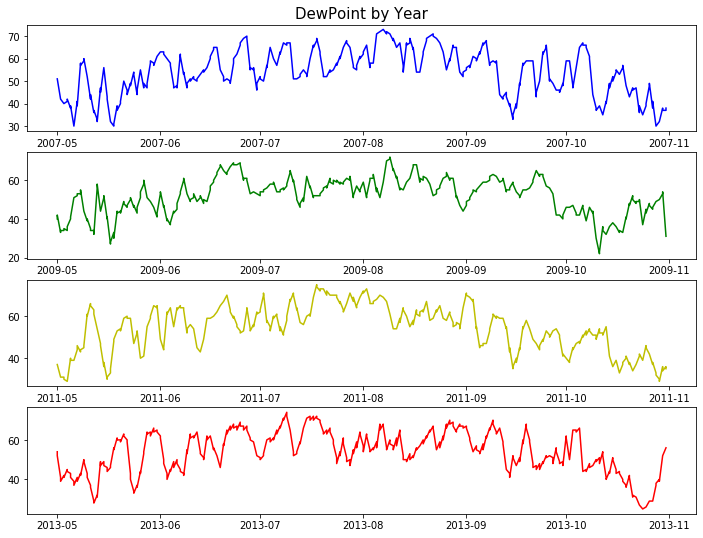

In [49]:
# Plot Dewpoint Temperature Across the Years

fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("DewPoint by Year", fontsize=15)
axes[0].plot(temp_df['2007-05' : '2007-12']['DewPoint'],c='b') # first plot
axes[1].plot(temp_df['2009-05' : '2009-12']['DewPoint'],c='g') # second plot
axes[2].plot(temp_df['2011-05' : '2011-12']['DewPoint'],c='y') # third plot
axes[3].plot(temp_df['2013-05' : '2013-12']['DewPoint'],c='r'); # third plot

#### It can be observed that the average dewpoint temperature also peaks during the July-August period.

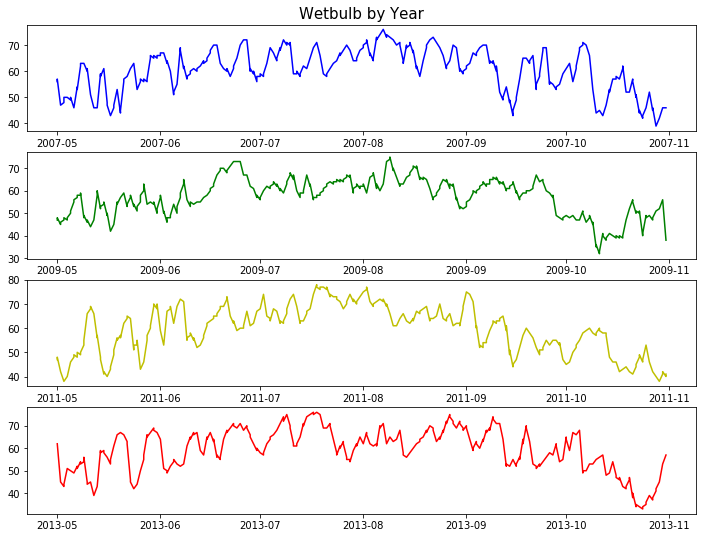

In [50]:
# Plot Wetbulb Temperature Across The Years

fig, axes = plt.subplots(nrows=4, figsize=(12,9))
axes[0].set_title("Wetbulb by Year", fontsize=15)
axes[0].plot(temp_df['2007-05' : '2007-12']['WetBulb'],c='b') # first plot
axes[1].plot(temp_df['2009-05' : '2009-12']['WetBulb'],c='g') # second plot
axes[2].plot(temp_df['2011-05' : '2011-12']['WetBulb'],c='y') # third plot
axes[3].plot(temp_df['2013-05' : '2013-12']['WetBulb'],c='r') # third plot

#### It can be observed that the average dewpoint temperature also peaks during the July-August period.

### Creating CountPlot Function

In [51]:
def draw_countplot(df, x, title, xlabel = None, ylabel = 'Number of Observations', hue = 'WnvPresent', loc = 'upper right', annot = True):
    fig, ax = plt.subplots(figsize=(18, 8))
    sns.set_style("white")
    sns.countplot(x = x, hue = hue, data = df, dodge = True, palette = ['blue', 'red'])
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    legend = plt.legend(loc = loc)
    legend.get_texts()[0].set_text('West Nile Virus Not Detected')
    legend.get_texts()[1].set_text('West Nile Virus Detected')
    
    if annot == True:
        for p in ax.patches:
            ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

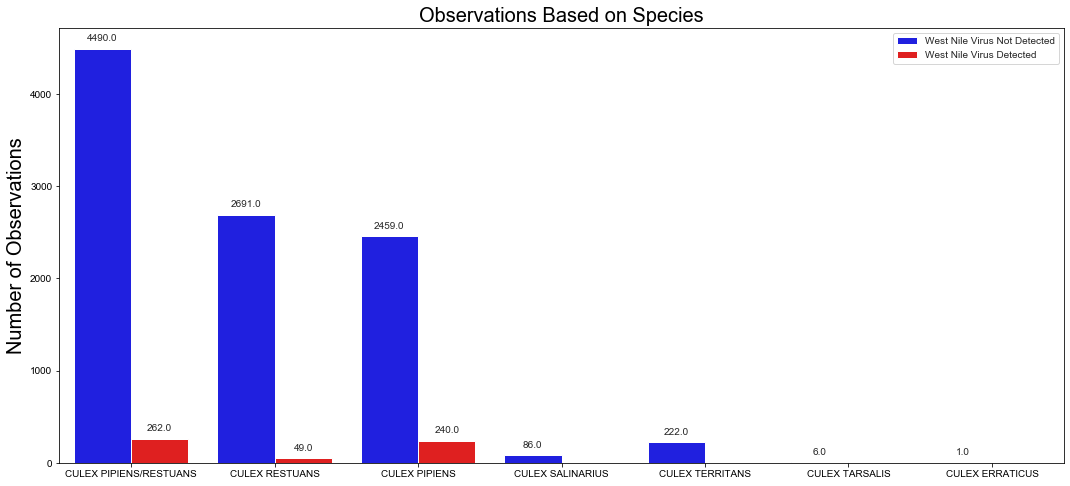

In [52]:
# Plot West Nile Observations Against Species

draw_countplot(train_weather, 'Species', 'Observations Based on Species', annot = True)

#### Only 3 species have been found to contain positive West Nile virus observations.

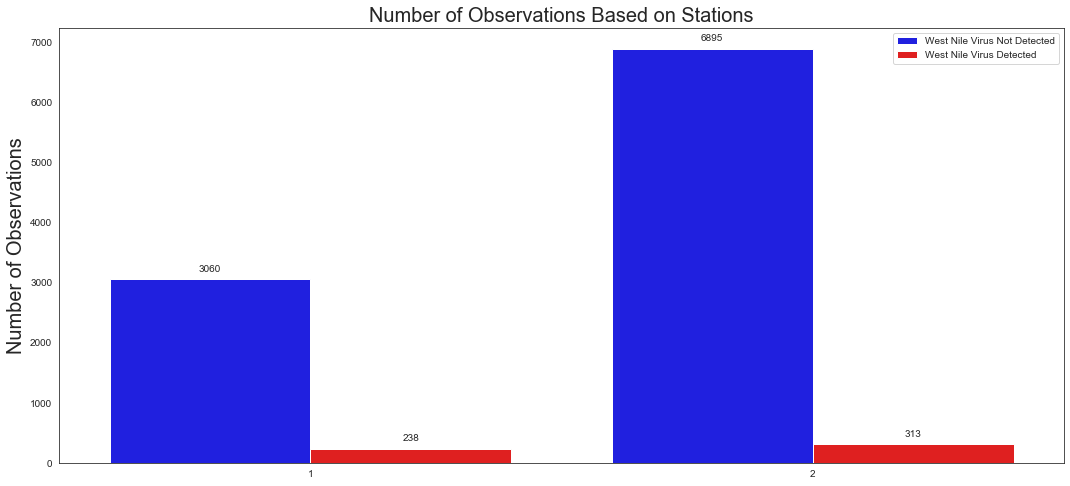

In [53]:
# Plot West Nile Observations Against Station

draw_countplot(train_weather, 'Station', 'Number of Observations Based on Stations')

#### Stations 1 and 2 have almost similar number of positive West Nile virus observations but Station 2 has comparably much more negative West Nile virus observations.

### Creating Barplot Function

In [54]:
from scipy.stats import norm

def draw_barplot (df, groupby, target, title, xlabel = None,  ylabel = 'Number of Observations', rotation = 0):
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.grid(False)
    df.groupby([groupby])[target].sum().plot.bar(color = 'r')
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
    ax.set_ylabel(ylabel, fontsize = 20)
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size = 10)

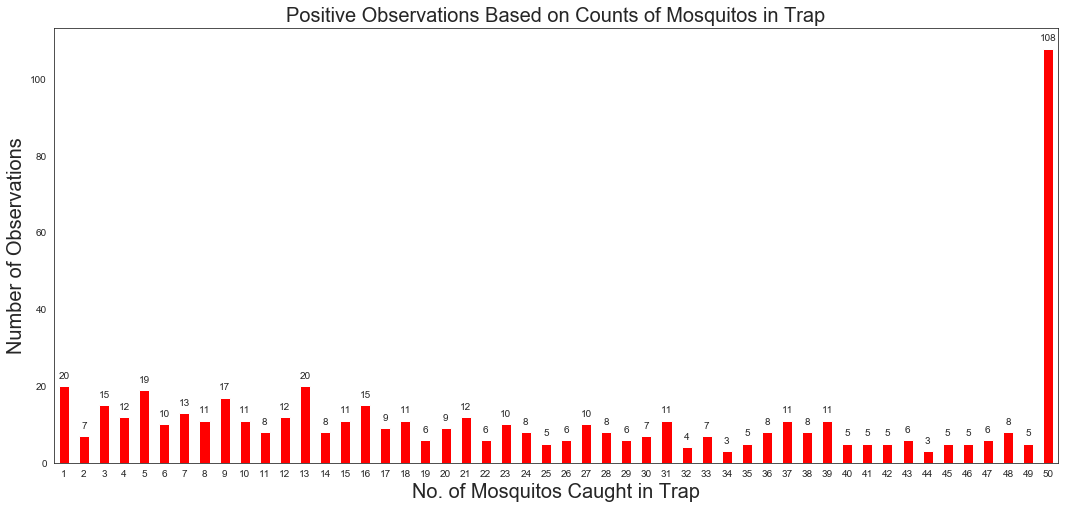

In [55]:
# Plot Positive West Nile virus counts based on number of mosquitoes caught in trap

draw_barplot(train_weather, 'NumMosquitos', 'WnvPresent', 'Positive Observations Based on Counts of Mosquitos in Trap', xlabel = "No. of Mosquitos Caught in Trap")

#### The above shows the presence of West Nile Virus based on the number of mosquitos caught by trap. For all traps with 50 mosquitos caughtes, the total count of positive observation is 108.

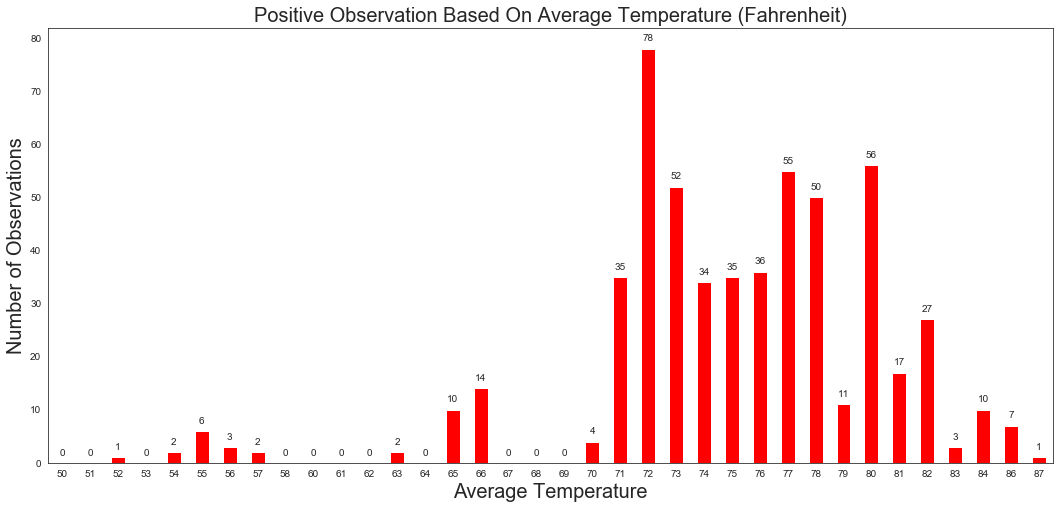

In [56]:
# Plot Positive West Nile virus counts based on Tavg temperature

draw_barplot(train_weather, 'Tavg', 'WnvPresent', 'Positive Observation Based On Average Temperature (Fahrenheit)', xlabel = 'Average Temperature')

#### The number of positive observations peaks when the average temperature is between 71F and 80F.

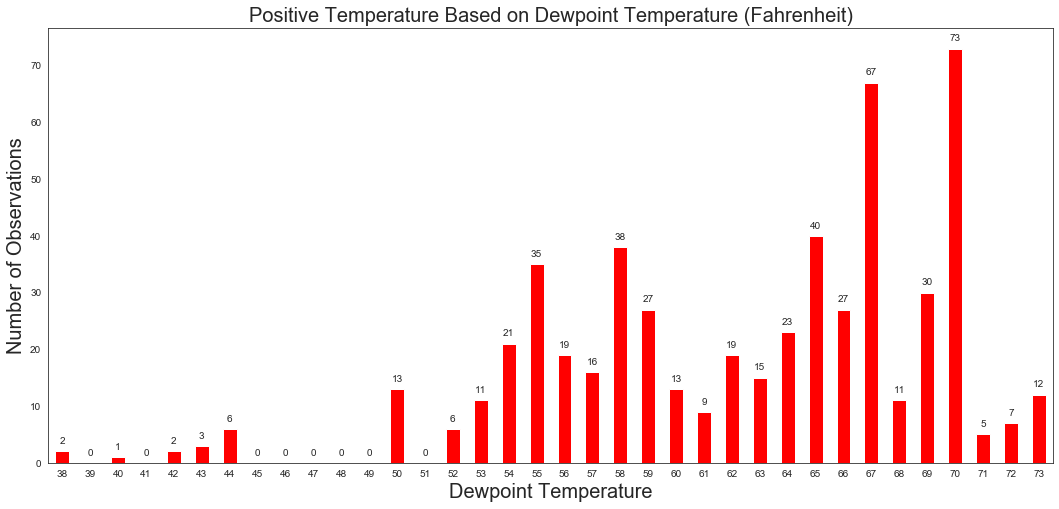

In [57]:
# Plot West Nile virus counts based on Dewpoint Temperature

draw_barplot(train_weather, 'DewPoint', 'WnvPresent', 'Positive Temperature Based on Dewpoint Temperature (Fahrenheit)', xlabel = 'Dewpoint Temperature')

#### The number of positive observations increases when the dew point is around 55F to 70F.

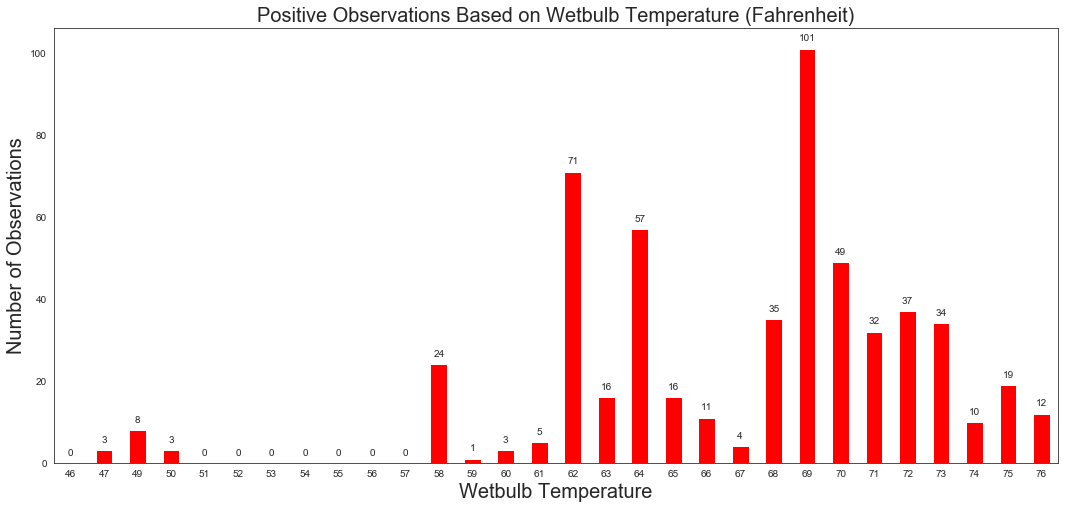

In [58]:
# Plot West Nile virus counts based on Wetbulb Temperature

draw_barplot(train_weather, 'WetBulb', 'WnvPresent', 'Positive Observations Based on Wetbulb Temperature (Fahrenheit)', xlabel = 'Wetbulb Temperature')

#### The number of positive observations increases when the wetbulb temperature is around 62F to 73F.

In [59]:
# Add new columns for year,month,week,day for further analysis
train_weather['year'] = train_weather['Date'].dt.year
train_weather['month'] = train_weather['Date'].dt.month
train_weather['week'] = train_weather['Date'].dt.week
train_weather['day'] = train_weather['Date'].dt.day

In [60]:
# Check on the time period of our datasets. We noticed that year 2007 and 2009 of spray data is not given.
print('train data')
print(train['Date'].dt.year.unique(),train['Date'].dt.month.unique())

print('test data')
print(test['Date'].dt.year.unique(),test['Date'].dt.month.unique())

print('weather data')
print(weather['Date'].dt.year.unique(),weather['Date'].dt.month.unique())

print('spray data')
print(spray['Date'].dt.year.unique(),spray['Date'].dt.month.unique())

train data
[2007 2009 2011 2013] [ 5  6  7  8  9 10]
test data
[2008 2010 2012 2014] [ 6  7  8  9 10]
weather data
[2007 2008 2009 2010 2011 2012 2013 2014] [ 5  6  7  8  9 10]
spray data
[2011 2013] [8 9 7]


In [61]:
train_weather.dtypes

Date               datetime64[ns]
Address                    object
Species                    object
Trap                       object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
Station                     int64
Tmax                        int64
Tmin                        int64
Tavg                        int64
Depart                      int64
DewPoint                    int64
WetBulb                     int64
Heat                        int64
Cool                        int64
Sunrise                    object
Sunset                     object
CodeSum                    object
Depth                       int64
SnowFall                  float64
PrecipTotal               float64
StnPressure               float64
SeaLevel                  float64
ResultSpeed               float64
ResultDir                   int64
AvgSpeed                  float64
year          

In [62]:
# Create function to feature-engineer new weather columns (1-7 days prior to current observation)

def create_7daysshift_col(df, col):
    df_test = df[['Date','Station']]
    for c in [1,2,3,4,5,6,7]:
        df_test = pd.concat([df_test,
        df[[col]].shift(c*2).rename(columns={col:col+'_'+str(c)+'dayb'})], axis=1)

    return df_test

In [63]:
# Create readings for following weather features

df1 = create_7daysshift_col(weather,'PrecipTotal')
df2 = create_7daysshift_col(weather,'DewPoint')
df3 = create_7daysshift_col(weather,'Tavg')
df4 = create_7daysshift_col(weather,'WetBulb')

df_7days = pd.concat([pd.concat([pd.concat([pd.concat([df1,df2],axis=1),df3],axis=1).drop(['Date','Station'],axis=1),
                           df4],axis=1)],axis=1)
df_7days.set_index(['Date','Station'],inplace=True)

In [64]:
df_7days

PrecipTotal_1dayb  PrecipTotal_2dayb  PrecipTotal_3dayb  \
Date       Station                                                            
2007-05-01 1                      NaN                NaN                NaN   
           2                      NaN                NaN                NaN   
2007-05-02 1                     0.00                NaN                NaN   
           2                     0.00                NaN                NaN   
2007-05-03 1                     0.00               0.00                NaN   
...                               ...                ...                ...   
2014-10-29 2                     0.03               0.02               0.00   
2014-10-30 1                     0.00               0.00               0.00   
           2                     0.00               0.03               0.02   
2014-10-31 1                     0.00               0.00               0.00   
           2                     0.00               0.00               0.03   

                    PrecipTotal_4dayb  PrecipTotal_5dayb  PrecipTotal_6dayb  \
Date       Station                                                            
2007-05-01 1                      NaN                NaN                NaN   
           2                      NaN                NaN                NaN   
2007-05-02 1                      NaN                NaN                NaN   
           2                      NaN                NaN                NaN   
2007-05-03 1                      NaN                NaN                NaN   
...                               ...                ...                ...   
2014-10-29 2                     0.00                0.0                0.0   
2014-10-30 1                     0.00                0.0                0.0   
           2                     0.00                0.0                0.0   
2014-10-31 1                     0.00                0.0                0.0   
           2                     0.02                0.0                0.0   

                    PrecipTotal_7dayb  DewPoint_1dayb  DewPoint_2dayb  \
Date       Station                                                      
2007-05-01 1                      NaN             NaN             NaN   
           2                      NaN             NaN             NaN   
2007-05-02 1                      NaN            51.0             NaN   
           2                      NaN            51.0             NaN   
2007-05-03 1                      NaN            42.0            51.0   
...                               ...             ...             ...   
2014-10-29 2                      0.0            40.0            52.0   
2014-10-30 1                      0.0            32.0            38.0   
           2                      0.0            34.0            40.0   
2014-10-31 1                      0.0            34.0            32.0   
           2                      0.0            35.0            34.0   

                    DewPoint_3dayb  ...  Tavg_5dayb  Tavg_6dayb  Tavg_7dayb  \
Date       Station                  ...                                       
2007-05-01 1                   NaN  ...         NaN         NaN         NaN   
           2                   NaN  ...         NaN         NaN         NaN   
2007-05-02 1                   NaN  ...         NaN         NaN         NaN   
           2                   NaN  ...         NaN         NaN         NaN   
2007-05-03 1                   NaN  ...         NaN         NaN         NaN   
...                            ...  ...         ...         ...         ...   
2014-10-29 2                  33.0  ...        61.0        52.0        50.0   
2014-10-30 1                  51.0  ...        61.0        60.0        48.0   
           2                  52.0  ...        64.0        61.0        52.0   
2014-10-31 1                  38.0  ...        53.0        61.0        60.0   
           2                  40.0  ...        55.0        64.0   

In [65]:
# Merge train and weather datasets

train_weather = pd.merge(train_weather,df_7days,how='left', on=['Date','Station'])

In [66]:
# Merge test and weather datasets

test_weather = pd.merge(test_weather,df_7days,how='left', on=['Date','Station'])

## Modelling

In [67]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_weather.dtypes

Date                 datetime64[ns]
Address                      object
Species                      object
Trap                         object
Latitude                    float64
Longitude                   float64
AddressAccuracy               int64
NumMosquitos                  int64
WnvPresent                    int64
Station                       int64
Tmax                          int64
Tmin                          int64
Tavg                          int64
Depart                        int64
DewPoint                      int64
WetBulb                       int64
Heat                          int64
Cool                          int64
Sunrise                      object
Sunset                       object
CodeSum                      object
Depth                         int64
SnowFall                    float64
PrecipTotal                 float64
StnPressure                 float64
SeaLevel                    float64
ResultSpeed                 float64
ResultDir                   

In [68]:
test_weather.dtypes

Id                            int64
Date                 datetime64[ns]
Address                      object
Species                      object
Trap                         object
Latitude                    float64
Longitude                   float64
AddressAccuracy               int64
Station                       int64
Tmax                          int64
Tmin                          int64
Tavg                          int64
Depart                        int64
DewPoint                      int64
WetBulb                       int64
Heat                          int64
Cool                          int64
Sunrise                      object
Sunset                       object
CodeSum                      object
Depth                         int64
SnowFall                    float64
PrecipTotal                 float64
StnPressure                 float64
SeaLevel                    float64
ResultSpeed                 float64
ResultDir                     int64
AvgSpeed                    

In [69]:
train_weather.shape

(10506, 61)

In [70]:
test_weather.shape

(116293, 56)

In [71]:
# Drop columns for train and test weather datasets
cols_to_drop = ['Date', 'NumMosquitos','Latitude','Longitude', 'year','month','week','day', 'Address','AddressAccuracy','Depth', 'SnowFall']
train_weather.drop(cols_to_drop,axis=1,inplace=True)

cols_to_drop = ['Date', 'Latitude','Longitude','Address','AddressAccuracy','Depth', 'SnowFall']
test_weather.drop(cols_to_drop,axis=1,inplace=True)

In [72]:
#Before one-hot encoding for train_final, test_final, need to merge them first
train_weather['is_train'] = 1
test_weather['is_train'] = 0
train_weather['Id'] = 0
test_weather['WnvPresent'] = 9

In [73]:
#Rearrange the column order in both train and test before merge them for one-hot encoding
columnsTitles = train_weather.columns
train_weather = train_weather.reindex(columns=columnsTitles)
test_weather = test_weather.reindex(columns=columnsTitles)

In [74]:
#One-hot encoding for train_final, test_final, merge them
df_combined = pd.concat([train_weather, test_weather],axis=0)

In [75]:
df_combined.shape

(126799, 51)

In [76]:
#Perform one-hot encoding
object_columns = ['Species','CodeSum','Trap']

df_combined = pd.get_dummies(df_combined, columns = object_columns, drop_first = False)
df_combined.shape

(126799, 242)

In [77]:
#Split the combined set into train set and test set
df_train = df_combined[df_combined['is_train']==1]
df_test = df_combined[df_combined['is_train']==0]

In [78]:
#Drop columns created previously for merging for one-hot encoding
df_train = df_train.drop(['Id','is_train'],axis=1)
df_test = df_test.drop(['WnvPresent','is_train'],axis=1)

In [79]:
df_train.shape

(10506, 240)

In [80]:
df_train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [81]:
df_test.shape

(116293, 240)

In [82]:
X = df_train.loc[:,df_train.columns!='WnvPresent']
y = df_train['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [83]:
# Applying SMOTE
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_sample(X_train, y_train)

In [84]:
y_train.value_counts()

1    7466
0    7466
Name: WnvPresent, dtype: int64

In [85]:
features = X.columns

In [86]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Feature Selection

In [87]:
pca = PCA()
p_train = pca.fit_transform(X_train_sc)
p_test = pca.transform(X_test_sc)

In [88]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 140 components): {np.round(var_exp[:140],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 140 components): {np.round(cum_var_exp[:140],3)}')

Explained variance (first 140 components): [0.07  0.032 0.022 0.016 0.015 0.011 0.01  0.009 0.008 0.008 0.007 0.007
 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005]

Cumulative explained variance (first 140 components): [0.07  0.102 0.124 0.14  0.155 0.165 0.176 0.185 

In [89]:
# number of components
n_pcs= pca.components_.shape[0]
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [90]:
# get the names
most_important_names = [X.columns]
# print pca and feature names
pca_feature = list(zip(most_important, most_important_names[0][most_important],var_exp))
pca_feature

[(38, 'WetBulb_1dayb', 0.06995240485695738),
 (43, 'WetBulb_6dayb', 0.032477574330258926),
 (40, 'WetBulb_3dayb', 0.02195105268304372),
 (17, 'PrecipTotal_1dayb', 0.015920539431096087),
 (9, 'Sunrise', 0.014571937545201589),
 (19, 'PrecipTotal_3dayb', 0.01058948212075165),
 (0, 'Station', 0.01042647666068921),
 (83, 'CodeSum_TSRA RA BR', 0.009143441285668585),
 (14, 'ResultSpeed', 0.008441151670170366),
 (60, 'CodeSum_No Sign', 0.008098953399511957),
 (47, 'Species_CULEX PIPIENS/RESTUANS', 0.007216962403027629),
 (23, 'PrecipTotal_7dayb', 0.007010510591756802),
 (55, 'CodeSum_BR HZ', 0.006609122914455609),
 (78, 'CodeSum_TSRA BR HZ', 0.006296710758317886),
 (78, 'CodeSum_TSRA BR HZ', 0.006241380973024108),
 (192, 'Trap_T149', 0.006189849729427405),
 (87, 'CodeSum_TSRA RA DZ BR HZ', 0.006060243162933046),
 (79, 'CodeSum_TSRA BR HZ VCTS', 0.005864562836018733),
 (77, 'CodeSum_TSRA BR', 0.005702716412166626),
 (51, 'Species_CULEX TERRITANS', 0.005632992639989422),
 (65, 'CodeSum_RA DZ BR'

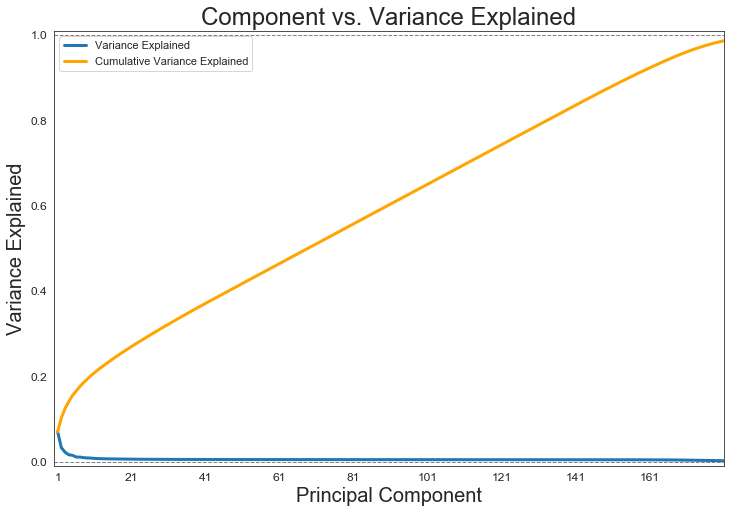

In [91]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,180])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 180, 20), range(1, 180, 20), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

In [92]:
top_feature_col = [x[1] for x in pca_feature][:134]

### GridSearch

In [93]:
def pipeline_gridsearch(pipe, pipe_params, X_train, y_train):
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
    gs.fit(X_train, y_train)
    print(gs.best_score_) # best_score_ is gridsearch's function
    print(gs.best_params_)# best_params_ is gridsearch's function

### Logistic Regression

In [94]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('logit', LogisticRegression())])

In [95]:
pipe_params = {  
    'logit__C' : [1, 2], 
    'logit__class_weight' : [None, 'balanced'],
    'logit__penalty' : ['l1', 'l2']}

In [96]:
pipeline_gridsearch(pipe,pipe_params, X_train[top_feature_col], y_train)

0.7864330159424935
{'logit__C': 1, 'logit__class_weight': None, 'logit__penalty': 'l2'}


### Random Forest

In [97]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())])

In [98]:
pipe_params_rf = {
    'rf__n_estimators' : [135,140,145],
    'rf__max_features' : [25,30,35],
    'rf__max_depth' : [50,55]
}

In [99]:
pipeline_gridsearch(pipe_rf,pipe_params_rf, X_train[top_feature_col], y_train)

0.8829371796651306
{'rf__max_depth': 55, 'rf__max_features': 35, 'rf__n_estimators': 145}


### Decision Tree Classifier

In [100]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('dt', DecisionTreeClassifier())])

In [101]:
pipe_params = {
    'dt__max_depth' : [7, 10],
    'dt__min_samples_split' : [5, 10],
    'dt__min_samples_leaf' : [2, 3],
    }

In [102]:
pipeline_gridsearch(pipe,pipe_params, X_train[top_feature_col], y_train)

0.8579562116795015
{'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}


### (Random Forest) Fitting With Best Parameters

In [103]:
X_new = X_train[top_feature_col]
y_new = y_train
X_new_test = df_test[top_feature_col]

In [104]:
ss = StandardScaler()

In [105]:
X_new = ss.fit_transform(X_new)
X_new_test = ss.transform(X_new_test)

In [106]:
X_new.shape, y_new.shape, X_new_test.shape

((14932, 134), (14932,), (116293, 134))

In [107]:
best_rf = RandomForestClassifier(n_estimators = 145, max_features = 35, max_depth= 50)

In [108]:
best_rf.fit(X_new, y_new)
print('Training Score: {}'.format(round(best_rf.score(X_new, y_new), 4)))

Training Score: 0.9191


In [109]:
y_test_new = best_rf.predict(X_new)

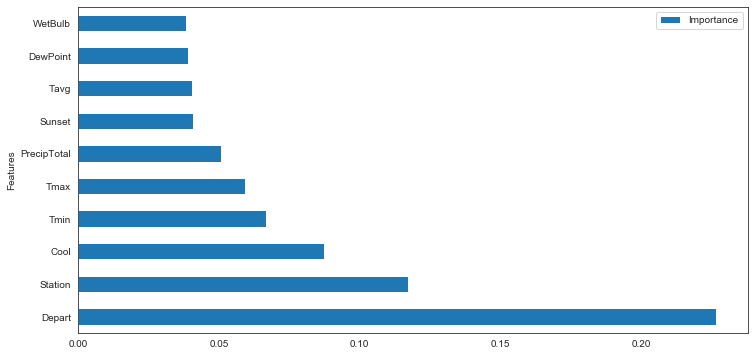

In [110]:
features = pd.DataFrame(list(zip(X.columns, best_rf.feature_importances_)), columns = ['Features', 'Importance'])
features.sort_values(by = 'Importance', ascending = False).head(10).plot(kind = 'barh', x = 'Features', y = 'Importance', figsize = (12, 6));

### Model Evaluation

In [111]:
cm_1 = confusion_matrix(y_new, y_test_new)

In [112]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = cm_1.ravel()

print(f'True Neg: {tn}')
print(f'False Pos: {fp}')
print(f'False Neg: {fn}')
print(f'True Pos: {tp}')

True Neg: 6601
False Pos: 865
False Neg: 343
True Pos: 7123


In [113]:
cm_df_1 = pd.DataFrame(cm_1, columns=['pred Wnv Not Present', 'Wnv Present'], index=['actual Wnv Not Present', 'actual Wnv Present'])
cm_df_1

,pred Wnv Not Present,Wnv Present
actual Wnv Not Present,6601,865
actual Wnv Present,343,7123


In [114]:
# Number of correct positive predictions divided by total number of positives

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9541


In [115]:
# Number of correct negative predictions divided by the total number of negatives

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.8841


In [116]:
y_pred = best_rf.predict_proba(X_new_test)[:,1]

In [117]:
output = pd.DataFrame({'Id': df_test['Id'], 'WnvPresent': y_pred})
output.to_csv('./rf_proba.csv', index=False)

## Cost-Benefit Analysis & Recommendations

In [118]:
spray['Date'] = pd.to_datetime(spray['Date'])
train['Date'] = pd.to_datetime(train['Date'])

In [119]:
spray['year'] = spray['Date'].dt.year
spray['month'] = spray['Date'].dt.month
spray['week'] = spray['Date'].dt.week
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['week'] = train['Date'].dt.week

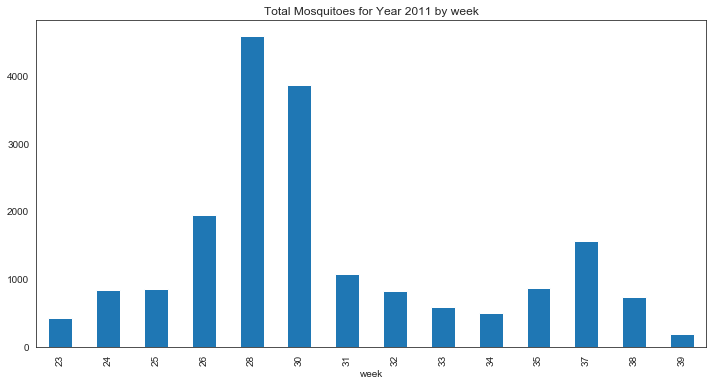

In [120]:
train[train['year'] == 2011].groupby(['week'])['NumMosquitos'].sum().plot(kind = 'bar', title = 'Total Mosquitoes for Year 2011 by week', figsize = (12, 6))

In [121]:
spray[(spray['year']== 2011)]['week'].unique()

array([35, 36])

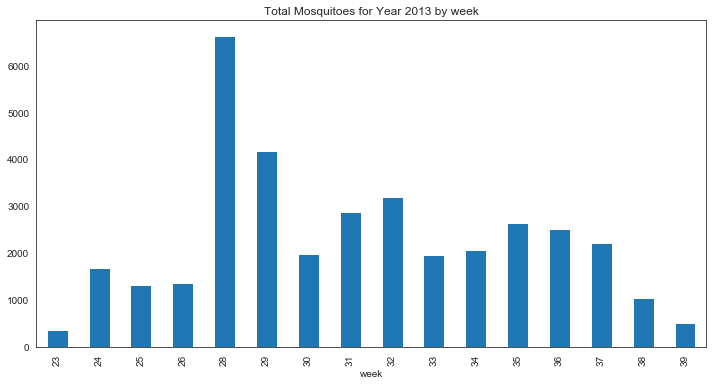

In [122]:
train[train['year'] == 2013].groupby(['week'])['NumMosquitos'].sum().plot(kind = 'bar', title = 'Total Mosquitoes for Year 2013 by week', figsize = (12, 6));

In [123]:
spray[(spray['year']== 2013)]['week'].unique()

array([29, 30, 32, 33, 34, 35, 36])

In [124]:
spray[(spray['year']== 2013) & (spray['week']== 29)].head()

,Date,Time,Latitude,Longitude,year,month,week
2209,2013-07-17,19:45:45,41.997728,-87.767532,2013,7,29
2210,2013-07-17,19:45:55,41.997990,-87.768085,2013,7,29
2211,2013-07-17,19:46:05,41.998237,-87.768623,2013,7,29
2212,2013-07-17,19:46:15,41.998510,-87.769225,2013,7,29
2213,2013-07-17,19:46:25,41.998793,-87.769833,2013,7,29


In [125]:
spray[(spray['year']== 2013) & (spray['week']== 32)].head()

,Date,Time,Latitude,Longitude,year,month,week
6018,2013-08-08,20:22:35,41.919128,-87.696737,2013,8,32
6019,2013-08-08,20:23:05,41.918935,-87.696405,2013,8,32
6020,2013-08-08,20:23:15,41.918665,-87.695948,2013,8,32
6021,2013-08-08,20:23:25,41.918520,-87.695568,2013,8,32
6022,2013-08-08,20:23:45,41.918023,-87.694743,2013,8,32


We conclude our best ML model to be RandomForestClassifier, with a Kaggle Private Score of 0.64530 and Public Score of 0.6619.

We have identified the features that are deemed to be most influential in the prediction of West Nile Virus:

- Temperature measurements as higher temperatures would let mosquitoes reach biting age sooner and speed multiplication of the virus within insects.

- Humidity-related measurements as they can stimulate mosquitoes to bite and create pools of water in which they can breed.

As pesticide-spraying seems to have shown some effect in July and August in 2013, we suggest that these efforts can be concentrated within these two months.